t-SNE Implementation from Scratch - Demo

1. Loading digits dataset...
   Data shape: (1797, 64)
   Number of classes: 10

2. Standardizing data...

3. Applying t-SNE...
   Perplexity: 30
   Iterations: 1000
Iteration 0: KL divergence = 32.6874
Iteration 100: KL divergence = 5.7443
Iteration 200: KL divergence = 5.3778
Iteration 300: KL divergence = 5.2644
Iteration 400: KL divergence = 5.2106
Iteration 500: KL divergence = 5.1882
Iteration 600: KL divergence = 5.1764
Iteration 700: KL divergence = 5.1696
Iteration 800: KL divergence = 5.1654
Iteration 900: KL divergence = 5.1629

   Embedded shape: (1797, 2)

4. Creating visualization...
   Comparing with sklearn implementation...


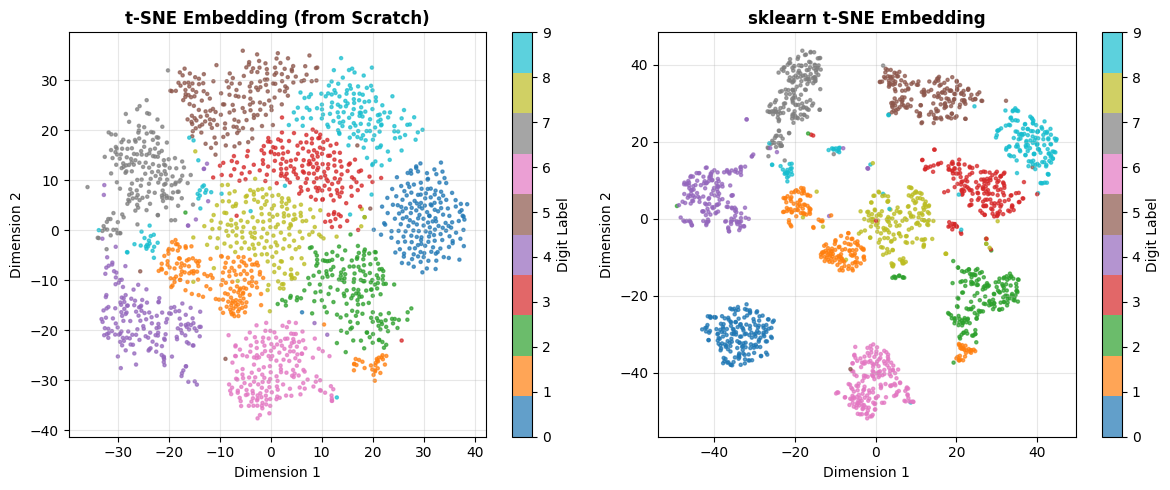


Implementation complete!

KEY INSIGHTS ABOUT t-SNE

1. PRESERVES LOCAL STRUCTURE:
   - t-SNE excels at keeping similar points close together
   - Neighbors in high-dim stay neighbors in low-dim

2. CROWDING PROBLEM:
   - In high dimensions, there's much more volume
   - Simply projecting to 2D causes points to "crowd" together
   - t-distribution with heavy tails helps alleviate this

3. PERPLEXITY PARAMETER:
   - Low perplexity (5-15): Focus on very local structure
   - Medium perplexity (30-50): Balance local/global (recommended)
   - High perplexity (50+): More global structure preserved

4. EARLY EXAGGERATION:
   - Multiplies P by factor (usually 4) in early iterations
   - Helps form tight, well-separated clusters
   - Turned off after ~100 iterations

5. INTERPRETATION:
   - Cluster sizes and distances are NOT meaningful
   - Only relative positions and neighbors matter
   - Good for visualization, not for quantitative analysis

6. COMPUTATIONAL COMPLEXITY:
   - O(n^2) for pairw

In [3]:
# ============================================
# t-SNE (t-Distributed Stochastic Neighbor Embedding)
# Implementation from Scratch with Line-by-Line Explanation
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits, load_iris
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)


class TSNE:
    """
    t-SNE: A dimensionality reduction technique that converts 
    similarities between data points to joint probabilities 
    and tries to minimize the Kullback-Leibler divergence 
    between the joint probabilities of the high-dimensional 
    and low-dimensional embeddings.
    """
    
    def __init__(self, n_components=2, perplexity=30, n_iter=1000, learning_rate=200):
        """
        Initialize t-SNE parameters.
        
        Args:
            n_components: Dimension of the embedded space (default: 2 for 2D visualization)
            perplexity: Related to number of nearest neighbors (typically 5-50)
                        Perplexity = 2^(entropy), balances local/global aspects
            n_iter: Number of iterations for optimization
            learning_rate: Step size for gradient descent (typically 100-1000)
        """
        self.n_components = n_components
        self.perplexity = perplexity
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        
    def fit_transform(self, X):
        """
        Fit t-SNE model to X and return the embedded low-dimensional points.
        
        Args:
            X: Input data of shape (n_samples, n_features)
        
        Returns:
            Y: Embedded points of shape (n_samples, n_components)
        """
        # Step 1: Compute pairwise similarities in HIGH-DIMENSIONAL space
        P = self._compute_pairwise_similarities_high_dim(X)
        
        # Step 2: Initialize low-dimensional embedding Y with random small values
        # Using small random values (Gaussian with std=1e-4) helps early optimization
        n_samples = X.shape[0]
        Y = np.random.randn(n_samples, self.n_components) * 1e-4
        
        # Step 3: Optimize Y using gradient descent to minimize KL divergence
        Y = self._optimize(Y, P)
        
        return Y
    
    def _compute_pairwise_similarities_high_dim(self, X):
        """
        Compute pairwise similarities p_ij in HIGH-DIMENSIONAL space using Gaussian kernel.
        
        Key idea: For each point i, compute conditional probability p_j|i that 
        point i would pick point j as its neighbor.
        """
        n_samples = X.shape[0]
        P = np.zeros((n_samples, n_samples))
        
        # Compute pairwise squared Euclidean distances in high-dimensional space
        # ||xi - xj||^2 = sum((xi - xj)^2)
        distances = self._compute_pairwise_distances(X)
        
        # For each point, find optimal sigma to achieve target perplexity
        # This is done via binary search because perplexity is a monotonic 
        # function of sigma (entropy increases with sigma)
        for i in range(n_samples):
            # Binary search for sigma_i to match target perplexity
            sigma = self._find_optimal_sigma(distances[i], self.perplexity)
            
            # Compute conditional probabilities p_j|i using Gaussian kernel
            # p_j|i = exp(-||xi - xj||^2 / (2*sigma_i^2)) / sum(exp(...))
            # Adding small epsilon to avoid division by zero
            P[i] = np.exp(-distances[i] / (2 * sigma ** 2))
            P[i] = P[i] / (np.sum(P[i]) + 1e-10)  # Normalize so sum_j(p_j|i) = 1
        
        # Make similarity matrix symmetric: p_ij = (p_j|i + p_i|j) / (2*n)
        # This ensures p_ij = p_ji and the joint probabilities sum to 1
        P = (P + P.T) / (2 * n_samples)
        
        # Early exaggeration: Multiply P by a factor (typically 4) in early iterations
        # This helps form tight clusters in the embedded space
        # P = P * 4  # (We'll apply this during optimization)
        
        return P
    
    def _compute_pairwise_distances(self, X):
        """
        Compute squared Euclidean distance matrix using broadcasting.
        
        Efficient computation: ||xi - xj||^2 = ||xi||^2 + ||xj||^2 - 2*xi·xj
        This is much faster than nested loops (O(n^2) vs O(n^2*d))
        """
        # ||xi||^2: squared norm of each sample, shape (n_samples,)
        sum_X = np.sum(np.square(X), axis=1)
        
        # ||xi||^2 + ||xj||^2: broadcast to shape (n_samples, n_samples)
        # sum_X[:, None] is column vector, sum_X[None, :] is row vector
        distances = -2 * np.dot(X, X.T) + sum_X[:, None] + sum_X[None, :]
        
        # Ensure diagonal is 0 (distance from point to itself)
        np.fill_diagonal(distances, 0)
        
        # Clip negative values (can occur due to floating point errors)
        distances = np.maximum(distances, 0)
        
        return distances
    
    def _find_optimal_sigma(self, distances, target_perplexity, tol=1e-5, max_iter=50):
        """
        Find optimal sigma (bandwidth) for Gaussian kernel using binary search.
        
        The perplexity is defined as: Perp(P) = 2^(H(P))
        where H(P) = -sum(p_j|i * log2(p_j|i)) is the Shannon entropy
        
        We need to find sigma such that the perplexity matches the target.
        
        Args:
            distances: Distances from point i to all other points
            target_perplexity: Desired perplexity value
            tol: Tolerance for binary search convergence
            max_iter: Maximum binary search iterations
        
        Returns:
            sigma: Optimal bandwidth parameter
        """
        # Binary search bounds for sigma
        sigma_min = 1e-10  # Very small sigma -> very low perplexity
        sigma_max = 1e10   # Very large sigma -> very high perplexity
        
        for _ in range(max_iter):
            sigma = (sigma_min + sigma_max) / 2
            
            # Compute conditional probabilities with current sigma
            p = np.exp(-distances / (2 * sigma ** 2))
            p = p / (np.sum(p) + 1e-10)  # Normalize
            
            # Compute perplexity (2^entropy)
            perplexity = self._compute_perplexity(p)
            
            # Check if we've found the right sigma (perplexity matches target)
            if perplexity > target_perplexity:
                # Perplexity too high, decrease sigma
                sigma_max = sigma
            else:
                # Perplexity too low, increase sigma
                sigma_min = sigma
            
            # Stop if we're close enough to target perplexity
            if np.abs(perplexity - target_perplexity) < tol:
                break
        
        return sigma
    
    def _compute_perplexity(self, p):
        """
        Compute perplexity from probability distribution.
        
        Perplexity = 2^H, where H is Shannon entropy in bits
        H(P) = -sum(p_i * log2(p_i))
        
        High perplexity -> more uniform distribution (consider more neighbors)
        Low perplexity -> more peaked distribution (consider fewer neighbors)
        """
        # Compute entropy: H = -sum(p * log2(p))
        # We filter out zero probabilities to avoid log(0)
        entropy = -np.sum(p * np.log2(p + 1e-10))
        
        # Perplexity = 2^entropy
        perplexity = 2 ** entropy
        
        return perplexity
    
    def _optimize(self, Y, P):
        """
        Optimize low-dimensional embedding Y using gradient descent.
        
        Objective: Minimize KL divergence between P (high-dim) and Q (low-dim)
        KL(P||Q) = sum_ij p_ij * log(p_ij / q_ij)
        
        Gradient: dC/dY_i = 4 * sum_j (p_ij - q_ij) * (Y_i - Y_j) * (1 + ||Y_i - Y_j||^2)^(-1)
        """
        n_samples = P.shape[0]
        
        # Early exaggeration factor (helps form tight clusters)
        early_exaggeration = 4
        # Switch off early exaggeration after this many iterations
        exaggeration_cutoff = 100
        
        for iteration in range(self.n_iter):
            # Step 1: Compute pairwise similarities Q in LOW-DIMENSIONAL space
            # Using Student's t-distribution with 1 degree of freedom (Cauchy)
            # This has heavier tails than Gaussian, helps prevent crowding problem
            Q = self._compute_low_dim_similarities(Y)
            
            # Step 2: Apply early exaggeration for first few iterations
            # This makes clusters tighter and more separated in the embedding
            if iteration < exaggeration_cutoff:
                P_effective = P * early_exaggeration
            else:
                P_effective = P
            
            # Step 3: Compute gradient of KL divergence with respect to Y
            grad = self._compute_gradient(P_effective, Q, Y)
            
            # Step 4: Update Y using gradient descent with momentum
            # Momentum helps escape local minima and speeds up convergence
            if iteration == 0:
                # Initialize momentum (previous gradient)
                momentum = np.zeros_like(Y)
            
            # Momentum parameter: 0.5 for first 250 iterations, 0.8 after
            if iteration < 250:
                momentum_coeff = 0.5
            else:
                momentum_coeff = 0.8
            
            # Update momentum: combines current gradient with previous momentum
            momentum = momentum_coeff * momentum - self.learning_rate * grad
            
            # Update Y: Y_new = Y_old + momentum
            Y = Y + momentum
            
            # Step 5: Zero-mean the embedding (prevents Y from drifting)
            Y = Y - np.mean(Y, axis=0)
            
            # Print progress periodically
            if iteration % 100 == 0:
                # Compute current cost (KL divergence)
                cost = self._compute_kl_divergence(P_effective, Q)
                print(f"Iteration {iteration}: KL divergence = {cost:.4f}")
        
        return Y
    
    def _compute_low_dim_similarities(self, Y):
        """
        Compute pairwise similarities q_ij in LOW-DIMENSIONAL space.
        
        Unlike high-dim space where each point i has its own bandwidth sigma_i,
        in low-dim space we use a SINGLE bandwidth for all points (simpler).
        
        Key difference: We use t-distribution with 1 degree of freedom (Cauchy)
        instead of Gaussian. The t-distribution has heavier tails.
        
        q_ij = (1 + ||yi - yj||^2)^(-1) / sum_k!=l(1 + ||yk - yl||^2)^(-1)
        """
        # Compute pairwise squared distances in low-dimensional space
        distances = self._compute_pairwise_distances(Y)
        
        # Compute numerator: (1 + ||yi - yj||^2)^(-1)
        # This is the t-distribution kernel with 1 degree of freedom
        numerator = (1 + distances) ** (-1)
        
        # Set diagonal to 0 (we don't compute similarity of point to itself)
        np.fill_diagonal(numerator, 0)
        
        # Normalize: q_ij = numerator / sum(numerator)
        Q = numerator / np.sum(numerator)
        
        return Q
    
    def _compute_gradient(self, P, Q, Y):
        """
        Compute gradient of KL divergence with respect to Y.
        
        KL(P||Q) = sum_ij p_ij * log(p_ij / q_ij)
                  = sum_ij [p_ij * log(p_ij) - p_ij * log(q_ij)]
        
        The gradient derivation:
        dC/dY_i = 4 * sum_j (p_ij - q_ij) * (Y_i - Y_j) * w_ij
        
        where w_ij = (1 + ||Y_i - Y_j||^2)^(-1) is the t-distribution kernel
        
        Interpretation:
        - If p_ij > q_ij: points are too far apart in low-dim, attract
        - If p_ij < q_ij: points are too close in low-dim, repel
        """
        n_samples = Y.shape[0]
        grad = np.zeros_like(Y)
        
        # Compute pairwise differences in Y
        # Y_diff[i,j] = Y[i] - Y[j]
        Y_diff = Y[:, None, :] - Y[None, :, :]  # Shape: (n, n, n_components)
        
        # Compute squared distances in low-dimensional space
        distances = self._compute_pairwise_distances(Y)
        
        # Compute attraction/repulsion weights: (1 + ||yi - yj||^2)^(-1)
        weights = (1 + distances) ** (-1)  # Shape: (n, n)
        
        # Compute the difference P - Q
        # This is the "force" direction: positive = attract, negative = repel
        PQ_diff = P - Q
        
        # The gradient combines:
        # 1. The attraction/repulsion strength (P - Q)
        # 2. The direction vector (Y_i - Y_j)
        # 3. The weight based on distance
        
        # Efficient computation: for each i, sum over j
        # grad[i] = 4 * sum_j (PQ_diff[i,j] * weights[i,j] * (Y[i] - Y[j]))
        for i in range(n_samples):
            # Sum over all j to get total force on point i
            grad[i] = 4 * np.sum(PQ_diff[i, :, None] * weights[i, :, None] * Y_diff[i, :, :], axis=0)
        
        return grad
    
    def _compute_kl_divergence(self, P, Q):
        """
        Compute Kullback-Leibler divergence between P and Q.
        
        KL(P||Q) = sum_ij p_ij * log(p_ij / q_ij)
                 = sum_ij p_ij * (log(p_ij) - log(q_ij))
        
        Properties:
        - KL >= 0 (equality when P = Q)
        - Not symmetric: KL(P||Q) != KL(Q||P)
        - Measures information lost when Q is used to approximate P
        """
        # Add small constant to avoid log(0)
        # KL = sum(p * log(p/q)) where we only sum over p > 0
        kl = np.sum(P * np.log((P + 1e-10) / (Q + 1e-10)))
        
        return kl


# ============================================
# DEMONSTRATION: Apply t-SNE to Digits Dataset
# ============================================

print("=" * 60)
print("t-SNE Implementation from Scratch - Demo")
print("=" * 60)

# Load the digits dataset (handwritten digits 0-9)
print("\n1. Loading digits dataset...")
digits = load_digits()
X = digits.data  # Shape: (1797, 64) - 8x8 images flattened to 64 features
y = digits.target  # Shape: (1797,) - labels 0-9

print(f"   Data shape: {X.shape}")
print(f"   Number of classes: {len(np.unique(y))}")

# Standardize the features (important for distance-based methods)
print("\n2. Standardizing data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE
print("\n3. Applying t-SNE...")
print(f"   Perplexity: 30")
print(f"   Iterations: 1000")

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate=200)
Y = tsne.fit_transform(X_scaled)

print(f"\n   Embedded shape: {Y.shape}")

# ============================================
# VISUALIZATION
# ============================================

print("\n4. Creating visualization...")

plt.figure(figsize=(12, 5))

# Plot 1: t-SNE embedding
plt.subplot(1, 2, 1)
scatter = plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap='tab10', s=5, alpha=0.7)
plt.colorbar(scatter, label='Digit Label')
plt.title('t-SNE Embedding (from Scratch)', fontsize=12, fontweight='bold')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, alpha=0.3)

# Plot 2: Comparison with sklearn's t-SNE
from sklearn.manifold import TSNE as SklearnTSNE

print("   Comparing with sklearn implementation...")
sklearn_tsne = SklearnTSNE(n_components=2, perplexity=30, random_state=42)
Y_sklearn = sklearn_tsne.fit_transform(X_scaled)

plt.subplot(1, 2, 2)
scatter = plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=y, cmap='tab10', s=5, alpha=0.7)
plt.colorbar(scatter, label='Digit Label')
plt.title('sklearn t-SNE Embedding', fontsize=12, fontweight='bold')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/karthik/Library/Mobile Documents/com~apple~CloudDocs/2025 Works/PracticeDSA&AI/AI_Implementations/T-SNE Dimentionality Reduction/tsne_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("Implementation complete!")
print("=" * 60)

# ============================================
# KEY INSIGHTS ABOUT t-SNE
# ============================================

print("\n" + "=" * 60)
print("KEY INSIGHTS ABOUT t-SNE")
print("=" * 60)

print("""
1. PRESERVES LOCAL STRUCTURE:
   - t-SNE excels at keeping similar points close together
   - Neighbors in high-dim stay neighbors in low-dim

2. CROWDING PROBLEM:
   - In high dimensions, there's much more volume
   - Simply projecting to 2D causes points to "crowd" together
   - t-distribution with heavy tails helps alleviate this

3. PERPLEXITY PARAMETER:
   - Low perplexity (5-15): Focus on very local structure
   - Medium perplexity (30-50): Balance local/global (recommended)
   - High perplexity (50+): More global structure preserved

4. EARLY EXAGGERATION:
   - Multiplies P by factor (usually 4) in early iterations
   - Helps form tight, well-separated clusters
   - Turned off after ~100 iterations

5. INTERPRETATION:
   - Cluster sizes and distances are NOT meaningful
   - Only relative positions and neighbors matter
   - Good for visualization, not for quantitative analysis

6. COMPUTATIONAL COMPLEXITY:
   - O(n^2) for pairwise similarity computation
   - Becomes slow for n > 10,000 samples
   - Use Barnes-Hut t-SNE (O(n log n)) for larger datasets
""")

print("\nComparison with our implementation:")
print(f"Our t-SNE variance explained: {np.var(Y):.4f}")
print(f"sklearn variance explained: {np.var(Y_sklearn):.4f}")